In [ ]:
#check how many peptides
#then skip the segments calculation and gnomAD query, as it was alredy done
#retreave positions of PSMs that were left with hybrid filtering
#take new numbers

In [1]:
from explore_import import  *
import ionbot_preprocess as io
import data_preprocess as dt
import hpp_checker as hpp

import asyncio
import pickle
import time
import os
import itertools 
import time
import re
import ast
from scipy.spatial import distance
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import asyncio
warnings.simplefilter(action='ignore', category=FutureWarning)

from Download_UnimodDB import *

In [2]:
all_peptide_sequences=pickle.load(open('./../all_peptide_sequences_OP_7302.pkl', 'rb'))
is_unique=pickle.load(open('./../is_unique_OP_7302.pkl', 'rb'))

In [3]:
all_peptide_sequences_byprot={e:k for k,v in all_peptide_sequences.items() for e in v}

In [ ]:
OPfasta_file='./../ionbot_openprot/openprot_2_0_0-human-ensembl106+refseq+uniprot2022_06_01.fasta'
input_file = open(OPfasta_file)
OPfasta = SeqIO.to_dict(SeqIO.parse(OPfasta_file, "fasta"))

In [ ]:
#https://ftp.ensembl.org/pub/release-106/fasta/homo_sapiens/dna/
ENSfasta_file="./ionbot_openprot/Homo_sapiens.GRCh38.dna.primary_assembly.fa"
input_file = open(ENSfasta_file)
ENSfasta = SeqIO.to_dict(SeqIO.parse(ENSfasta_file, "fasta"))

In [5]:
with open('combined_first_datasets.pickle', 'rb') as handle:
    combined_first_datasets=pickle.load(handle)

In [6]:
def Download_Unimod_Dict_names():
    unimod = Download_UnimodDB()
    condensed_unimod = {}
    for uni_id,df in unimod.groupby("unimod_id").__iter__():
        condensed_unimod[uni_id] = {}
        condensed_unimod[uni_id]['residues'] = "".join([_ for _ in df.residue if '-' not in _])
        condensed_unimod[uni_id]['mono_mass'] = [_ for _ in set(df.mono_mass)][0]
        condensed_unimod[uni_id]['code_name'] = [_ for _ in set(df.code_name)][0]
        condensed_unimod[uni_id]['full_name'] = [_ for _ in set(df.full_name)][0]
        
    return condensed_unimod

In [7]:
# 3-letter to 1-letter amino acid mapping
aa_map = {
    "Ala": "A", "Cys": "C", "Asp": "D", "Glu": "E", "Phe": "F",
    "Gly": "G", "His": "H", "Ile": "I", "Lys": "K", "Leu": "L",
    "Met": "M", "Asn": "N", "Pro": "P", "Gln": "Q", "Arg": "R",
    "Ser": "S", "Thr": "T", "Val": "V", "Trp": "W", "Tyr": "Y",
    "Xle": "L",  # Xle usually refers to Leu/Ile, mapped to Leu ("L") here
    "CamCys": "C", "MetOx": "M"  # Optional: include PTMs if needed
}

# Your list of mutations
mutations = ['His2Asn', 'His2Asp', 'Ala->Ser', 'Ala->Thr', 'Ala->Asp', ...]  # etc.

# Function to extract 1-letter code of the target amino acid
def extract_target_aa(mutation):
    if "->" in mutation:
        target = mutation.split("->")[1]
    elif "2" in mutation:
        target = mutation.split("2")[1]
    else:
        return None  # or raise error if unexpected format

    return aa_map.get(target, "?")  # return '?' if unknown


In [8]:
def get_peptide_position_io(s):
    match = re.search(r"\(\((\d+)-(\d+)\)\)", s)    
    return (int(match.group(1)) , int(match.group(2))) if match else None

def filter_nested_intervals(intervals):
    if len(intervals)==1: return True
    # Sort by start ascending, and end descending to prioritize wider intervals
    sorted_intervals = sorted(intervals, key=lambda x: (x[0], -x[1]))
    result = []

    for i, (start_i, end_i) in enumerate(sorted_intervals):
        is_nested = False
        for j, (start_j, end_j) in enumerate(sorted_intervals):
            if i != j and start_j <= start_i and end_i <= end_j:
                is_nested = True
                break
        if not is_nested:
            result.append((start_i, end_i))
    result_bool=[i in result for i in intervals]
    #print(result_bool)
    return result_bool
def filter_short_overlaps(i,overlapping_intervals):
    indexes,intervals = overlapping_intervals
    for indx,interval in zip(indexes,intervals):
        #print(indx,interval)
        if i in indx and len(indx)==1:
            #print(indx)
            return True
        elif i in indx and len(indx)>1:
            #print(indx,interval,abs(interval[0]-interval[1]))
            return abs(interval[0]-interval[1])>=18
        else:
            continue
def check_2_pep(group):
    return len(group)>=2

In [9]:
unimod = Download_Unimod_Dict_names()
unimod_df=pd.DataFrame.from_dict(unimod, orient='index')
#mark substitutions
unimod_df["isSubstitution"]=unimod_df.full_name.apply(lambda x: "substitution" in x)
unimod_df_subs=unimod_df[unimod_df["isSubstitution"]]
#to what residue is change
unimod_df_subs["subs_to_residue"]=unimod_df_subs.code_name.apply(lambda x: extract_target_aa(x))

/tmp/ipykernel_1044325/210214903.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unimod_df_subs["subs_to_residue"]=unimod_df_subs.code_name.apply(lambda x: extract_target_aa(x))


In [10]:
len(unimod)

1565

#### select peptides with potential substitutions

In [11]:
comb_datasets=pd.DataFrame()
for dataset_name,subdict in combined_first_datasets.items():
    df=subdict["openprot"]
    df["dataset"]=dataset_name
    comb_datasets=pd.concat([comb_datasets,df])
comb_datasets.reset_index(drop=True,inplace=True)
comb_datasets["peptide_length"]=comb_datasets.database_peptide.apply(lambda x: len(x))
comb_datasets["peptide_position"]=comb_datasets.proteins.apply(lambda x: [get_peptide_position_io(s) for s in x.split("||")])

In [108]:
#total psms with mass shift)
len(comb_datasets[comb_datasets.modifications!="Unmodified"])

117062

In [12]:
#take only peptides unique to class

comb_datasets_clun=comb_datasets[comb_datasets.peptide_class.isin(["unique_to_Noncanon","unique_to_Canon"])]
print(len(comb_datasets_clun))

18655


In [13]:
#identify peptides that have at least 1 PSM with a substitution mass shift, filter those that do not

peps_wsub=comb_datasets_clun.groupby("database_peptide").apply(lambda x: any(x.isSubstitution))
comb_datasets_clun=comb_datasets_clun[comb_datasets_clun.database_peptide.isin(peps_wsub[peps_wsub].index)]
print(len(comb_datasets_clun))

12292


/tmp/ipykernel_1044325/1104008463.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peps_wsub=comb_datasets_clun.groupby("database_peptide").apply(lambda x: any(x.isSubstitution))


In [14]:
#now check that the expected residues of these mass shifts are present in the peptides (without concidering predicted PTM position)
#coution false also can meed Unmodified or non-substitution ptm

comb_datasets_clun["isSubstitution_residue"]=comb_datasets_clun.apply(lambda x: False if x["modifications_masses"]=="Unmodified" else
                                                                                      any( any(aa in unimod_df_subs[unimod_df_subs.mono_mass==mass].residues.tolist() for aa in x["database_peptide"]) for _,_,mass in x["modifications_masses"]),axis=1)


In [15]:
#filter out mass shifts of potential substitutuins, where peptide does not contain the expected residue

peps_wsub_res=comb_datasets_clun[(comb_datasets_clun.isSubstitution)&(comb_datasets_clun.isSubstitution_residue)].database_peptide.unique()
comb_datasets_clun=comb_datasets_clun[comb_datasets_clun.database_peptide.isin(peps_wsub_res)]
print(len(comb_datasets_clun))

12292


/tmp/ipykernel_1044325/4134410897.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a=comb_datasets_clun.groupby("database_peptide").apply(lambda x: Counter(x.isSubstitution_residue)[True]/len(x))


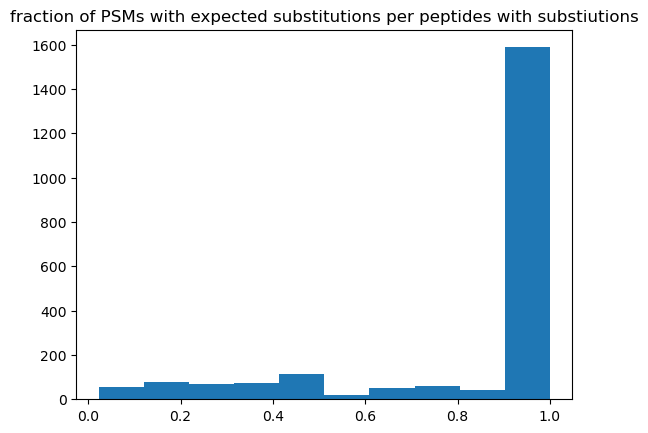

In [16]:
#how many PSMs of these peptides with potential substitutions have potential substitution

a=comb_datasets_clun.groupby("database_peptide").apply(lambda x: Counter(x.isSubstitution_residue)[True]/len(x))
plt.hist(a);
plt.title("fraction of PSMs with expected substitutions per peptides with substiutions");

In [17]:
#with at least one PSM with isoSAAV
comb_datasets_clun.drop_duplicates("database_peptide").peptide_class.value_counts()

peptide_class
unique_to_Canon       1431
unique_to_Noncanon     721
Name: count, dtype: int64

In [33]:
#by protein
comb_datasets_clun.drop_duplicates("proteins_list").peptide_class.value_counts()

peptide_class
unique_to_Canon       992
unique_to_Noncanon    560
Name: count, dtype: int64

In [18]:
#out of
comb_datasets[comb_datasets.peptide_class.isin(["unique_to_Noncanon","unique_to_Canon"])].drop_duplicates("database_peptide").peptide_class.value_counts()

peptide_class
unique_to_Canon       3458
unique_to_Noncanon    1053
Name: count, dtype: int64

In [27]:
1431/3458 ,  721/1053

(0.41382301908617697, 0.6847103513770181)

## Skip

#### creat all possible peptides with expected substitutions

In [88]:
#creat all possible peptides with expected substitutions

columns=["database_peptide","peptide_class","leadprot",'peptide_length', 'peptide_position','isSubstitution']
list_columns=['dataset','spectrum_title', 'scan', 'spectrum_file','observed_retention_time', 'charge','modifications_masses']
new_columns=["fraction_psm_wsub","modifications_set","residues_to_sub","pos_to_sub","sub_rule","peptides_w1sub","saav_info_pep"]
comb_clun_isosub=pd.DataFrame(columns=columns+list_columns+new_columns)
for database_peptide,group in comb_datasets_clun.groupby("database_peptide"):
    #print(database_peptide)
    #print(group[["database_peptide","modifications_masses"]])
    mods=set([e for l in group.modifications_masses if l!="Unmodified" for e in l ])
    ##mod_res=set([aa for _,aa,mass in mods if mass in unimod_df_subs.mono_mass.unique()]) #.. what if seidue is incorrect
    ##mod_res_poss=[i for i,aa in enumerate(database_peptide) if aa in mod_res]
    #residues expected to be substituted -> #residues after substitution
    exp_res=[list(unimod_df_subs[unimod_df_subs.mono_mass==mass][["residues","subs_to_residue"]].itertuples(index=False)) for _,aa,mass in mods if mass in unimod_df_subs.mono_mass.unique()]
    exp_res=set([e for l in exp_res for e in l])
    #same residue can be subst to several other because od diff mass shifts, so keep tuple
    exp_res=[(list(exp_res)[i].residues,list(exp_res)[i].subs_to_residue) for i in range(len(exp_res))]
    #filter where 1st residue is not in peptide
    exp_res=[(aa,_) for aa,_ in exp_res if aa in database_peptide]
    #positions of potential substiutions
    mod_res=set([aa for aa,_ in exp_res])
    mod_res_poss=[i for i,aa in enumerate(database_peptide) if aa in mod_res]
    
    exp_peptides=[database_peptide[:i] + aa_sub + database_peptide[i+1:] for i in mod_res_poss for aa,aa_sub in exp_res if database_peptide[i]==aa]
    #first is new aa and second is ref aa
    saav_info=[(i,a,b) for exp_pep in exp_peptides for i,(a,b) in enumerate(zip(exp_pep,database_peptide)) if a!=b]
    
    #print(database_peptide,mod_res,mod_res_poss,exp_res,exp_peptides)
    tmp=group[columns].iloc[0]
    for col in list_columns:
        tmp[col]=group[col].tolist()
    tmp["fraction_psm_wsub"]=Counter(group.isSubstitution_residue)[True]/len(group)
    tmp["modifications_set"]=mods
    tmp["residues_to_sub"]=mod_res
    tmp["pos_to_sub"]=mod_res_poss
    tmp["sub_rule"]=exp_res
    tmp["peptides_w1sub"]=exp_peptides
    tmp["saav_info_pep"]=saav_info
    comb_clun_isosub=pd.concat([comb_clun_isosub,pd.DataFrame(tmp).T])
    #break

In [89]:
#comb_clun_isosub.to_pickle("comb_clun_isosub.pkl")

#### identify the genomic coordinates of potential saavs

In [98]:
def get_protpos_ofaa_inpep(posinpep,peptide_position):
        #adjust indexing from 1 
        posinprot=peptide_position[0][0]+1+posinpep
        return posinprot

In [99]:
#identify protein posisions of saav

comb_clun_isosub["saav_info_prot"]=comb_clun_isosub.apply(lambda x: [(get_protpos_ofaa_inpep(peppos,x["peptide_position"]),subto, tosub) for peppos, subto, tosub in x["saav_info_pep"]], axis=1)

In [101]:
#comb_clun_isosub.to_pickle("comb_clun_isosub.pkl")

In [86]:
#file was created in explore-3-noncanon-hpp.ipynb

OPcoords=pd.read_pickle("./openprot_query/OPcoords.pkl")

In [280]:
def check_OPcoords_accession_match(data):
    if data.accession.isna().all():
        #print("no accession")
        return False
    strand=data.strand.tolist()[0]
    if pd.isna(strand):
        #print("no accession matched")
        return False
    return True
    
def get_aa_triplet(protein,posav_aapos,OPcoords):#,givestrand=False, givechr=False, givegene=False):
    #if not ("_" in protein or protein.startswith("ENSP")): #uniprot
    #    data=OPcoords[OPcoords.accessions==protein]
    #else: #altprots, ensembl, refseq
    #    data=OPcoords[OPcoords.accession==protein]
    data=OPcoords[(OPcoords.accessions==protein)|(OPcoords.accession==protein)]
    #print(data, posav_aapos)
    is_acc=check_OPcoords_accession_match(data)
    if is_acc:
        strand=data.strand.tolist()[0]
        if strand==-1:
            try:
                triplet=data.triplets.tolist()[0][posav_aapos-1-1] #-1
            except IndexError:
                print(data, posav_aapos)
                return np.nan
        else:
            try:
                triplet=data.triplets.tolist()[0][posav_aapos-1-1] #
            except IndexError:
                return np.nan
        return triplet

def get_protein_info(protein,OPcoords,givestrand=False, givechr=False, givegene=False):
    #if not ("_" in protein or protein.startswith("ENSP")): #uniprot
    #    data=OPcoords[OPcoords.accessions==protein]
    #else: #altprots, ensembl, refseq
    #    data=OPcoords[OPcoords.accession==protein]
    data=OPcoords[(OPcoords.accessions==protein)|(OPcoords.accession==protein)]
    is_acc=check_OPcoords_accession_match(data)
    if is_acc:
        strand=data.strand.tolist()[0]
        if givestrand:
            return strand
        if givechr:
            return data.location_chr.tolist()[0]
        if givegene:
            return data.genes.tolist()[0]

In [281]:
#identify triplet of each substitution

saav_info_triplet=comb_clun_isosub.apply(lambda x: [(get_aa_triplet(x["leadprot"],protpos,OPcoords),subto, tosub) 
                                                    for protpos, subto, tosub in x["saav_info_prot"]], axis=1)
comb_clun_isosub["saav_info_triplet"]=saav_info_triplet
del saav_info_triplet

In [215]:
protein="A0A2R8YEA7"
data=OPcoords[(OPcoords.accessions==protein)|(OPcoords.accession==protein)]
len(data.triplets.iloc[0])

158

In [170]:
#comb_clun_isosub.to_pickle("comb_clun_isosub.pkl")

In [139]:
#how many accessions were not found? -> can not identify their saav potential

comb_clun_isosub.saav_info_triplet.apply(lambda x: not isinstance(x[0][0],list)).value_counts()[True]

np.int64(547)

In [140]:
# annotate chromosome, strand and gene
#note, OPcoords has genes only of uniprot sequences!

comb_clun_isosub["strand"]=comb_clun_isosub.apply(lambda x: get_protein_info(x["leadprot"],OPcoords,givestrand=True), axis=1)
comb_clun_isosub["chromosome"]=comb_clun_isosub.apply(lambda x: get_protein_info(x["leadprot"],OPcoords,givechr=True), axis=1)
comb_clun_isosub["gene"]=comb_clun_isosub.apply(lambda x: get_protein_info(x["leadprot"],OPcoords,givegene=True), axis=1)


In [141]:
#comb_clun_isosub.to_pickle("comb_clun_isosub.pkl")

In [643]:
reverse_compliment_dna={"A":"T","T":"A","C":"G","G":"C"}
aminoacid_table={
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],  # Alanine
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],  # Arginine
    'N': ['AAT', 'AAC'],  # Asparagine
    'D': ['GAT', 'GAC'],  # Aspartic acid
    'C': ['TGT', 'TGC'],  # Cysteine
    'Q': ['CAA', 'CAG'],  # Glutamine
    'E': ['GAA', 'GAG'],  # Glutamic acid
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],  # Glycine
    'H': ['CAT', 'CAC'],  # Histidine
    'I': ['ATT', 'ATC', 'ATA'],  # Isoleucine
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],  # Leucine
    'K': ['AAA', 'AAG'],  # Lysine
    'M': ['ATG'],  # Methionine (Start codon)
    'F': ['TTT', 'TTC'],  # Phenylalanine
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],  # Proline
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],  # Serine
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],  # Threonine
    'W': ['TGG'],  # Tryptophan
    'Y': ['TAT', 'TAC'],  # Tyrosine
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],  # Valine
    '*': ['TAA', 'TAG', 'TGA']  # Stop codons
}

aminoacid_table_rev={codon:aa for aa, codons in aminoacid_table.items() for codon in codons}

def get_codon_fromfasta(poss,chromosome,ENSfasta): #strand
    #print(poss)
    if isinstance(poss,float): return np.nan
    codon=[str(ENSfasta[chromosome].seq)[pos-1] for pos in poss]
    #rev_codon=None
    #if strand==-1:
    #        rev_codon=[reverse_compliment_dna[bp] for bp in codon]
    return codon #rev_codon


In [282]:
#get reference codon sequence, caution strand

comb_clun_isosub["saav_info_refcod"]=comb_clun_isosub.apply(lambda x: [(get_codon_fromfasta(triplet,x["chromosome"],ENSfasta),subto, tosub)  
                                                                       for triplet, subto, tosub in x["saav_info_triplet"]] 
                                                            if isinstance(x["saav_info_triplet"][0][0],list) else np.nan, axis=1)

In [283]:
comb_clun_isosub["saav_info_refcod_rev"]=comb_clun_isosub.apply(lambda x: [([reverse_compliment_dna[bp] for bp in codon] 
                                                                            if isinstance(codon,list) else np.nan
                                                                            ,subto, tosub) 
                                                                       for codon, subto, tosub in x["saav_info_refcod"]]
                                                                if x["strand"]==-1 and isinstance(x["saav_info_refcod"],list) else np.nan, axis=1)

In [ ]:
#if isinstance(codon,list) else np.nan

In [284]:
comb_clun_isosub.to_pickle("comb_clun_isosub.pkl")

In [296]:
def check_isexpected_aa(row,i,OPcoords,ENSfasta):
    #print(row["leadprot"],row["saav_info_refcod"][i],row["saav_info_triplet"][i][0])
    strand=row["strand"]
    codon= row["saav_info_refcod_rev"][i][0] if strand ==-1 else row["saav_info_refcod"][i][0]
    is_expected_aa="".join(codon) in aminoacid_table[row["saav_info_refcod"][i][2]]
    #correct weird cases - why?
    if not is_expected_aa:
        print("reference codon indeed encodes reference amino acid - ", is_expected_aa, row["leadprot"])
        #print(row)
        protein=row["leadprot"]
        data=OPcoords[(OPcoords.accessions==protein)|(OPcoords.accession==protein)]
        if strand==-1:
            new_triplet=data.triplets.tolist()[0][row["saav_info_prot"][i][0]-1]
        else:
            new_triplet=data.triplets.tolist()[0][row["saav_info_prot"][i][0]-1]
        new_codon=get_codon_fromfasta(new_triplet,row["chromosome"],ENSfasta)
        if strand==-1:
            new_codon_ref=new_codon
            new_codon=[reverse_compliment_dna[bp] for bp in new_codon]
        new_is_expected_aa="".join(new_codon) in aminoacid_table[row["saav_info_refcod"][i][2]]
        #if solved the case
        if new_is_expected_aa:
            print("new", new_is_expected_aa, strand, codon, new_codon, row["saav_info_triplet"][i][0], new_triplet)
            dat={"triplet":new_triplet,"refcod": new_codon_ref if strand==-1 else new_codon ,
                 "refcod_rev": new_codon if strand==-1 else np.nan , "is_expected_aa": new_is_expected_aa}
            return dat
         #not solvable cases - shift in codon and frame - weird
        else:
            print("new", new_is_expected_aa, strand, codon, new_codon, row["saav_info_triplet"][i][0], new_triplet)
            #print(row)
            return new_is_expected_aa
    else:
        return is_expected_aa

In [265]:
protein="IP_151829"
data=OPcoords[(OPcoords.accessions==protein)|(OPcoords.accession==protein)]
data.triplets.tolist()[0][30-1-1]

[39951384, 39951385, 39951386]

In [297]:
#check if it encodes an expected aa, if not -try to correct result
#I notice that we need left shift on 1 codon with forward strand
#and to 1 right in reverse

comb_clun_isosub["is_expected_aa"]=comb_clun_isosub.apply(lambda x: [check_isexpected_aa(x,i,OPcoords,ENSfasta)
                                                                       for i in range(len(x["saav_info_refcod"]))]
                                                                if isinstance(x["saav_info_refcod"],list) else np.nan, axis=1)

reference codon indeed encodes reference amino acid -  False H7C5E6
new False -1.0 ['C', 'G', 'G'] ['G', 'G', 'G'] [36024452, 36024451, 36024450] [36024449, 36024448, 36024447]
reference codon indeed encodes reference amino acid -  False H7C5E6
new False -1.0 ['C', 'T', 'G'] ['C', 'G', 'T'] [36024446, 36024445, 36024444] [36024443, 36024442, 36024441]
reference codon indeed encodes reference amino acid -  False H7C5E6
new False -1.0 ['C', 'G', 'T'] ['C', 'C', 'G'] [36024443, 36024442, 36024441] [36024440, 36024439, 36024438]
reference codon indeed encodes reference amino acid -  False H7C5E6
new False -1.0 ['C', 'A', 'C'] ['A', 'A', 'C'] [36019703, 36019702, 36019701] [36019700, 36019699, 36019698]
reference codon indeed encodes reference amino acid -  False H0Y9E9
new False -1.0 ['T', 'T', 'A'] ['T', 'T', 'G'] [60108194, 60108193, 60108192] [60108191, 60108190, 60108189]
reference codon indeed encodes reference amino acid -  False H0Y9E9
new False -1.0 ['T', 'T', 'G'] ['G', 'G', 'T'] 

In [298]:
#comb_clun_isosub.to_pickle("comb_clun_isosub.pkl")

In [299]:
#how many peptides have False is_expected_aa - 10
Counter(comb_clun_isosub.apply(lambda x: all(x["is_expected_aa"]) if isinstance(x["saav_info_refcod"],list) else True, axis=1))

Counter({True: 3027, False: 10})

In [1086]:
10/3037

0.0032927230819888046

In [319]:
len(comb_clun_isosub)

3037

In [321]:
#how many protein accessions were NOT found in OP
len(comb_clun_isosub[comb_clun_isosub.is_expected_aa.isna()].leadprot.unique())

450

In [1082]:
#comb_clun_isosub[comb_clun_isosub.is_expected_aa.isna()].leadprot.unique()[1]

In [1080]:
#OPcoords[(OPcoords.accessions=='B4DHC4')|(OPcoords.accession=='B4DHC4')]

In [1081]:
#comb_clun_isosub[comb_clun_isosub.leadprot=='B4DHC4']

In [334]:
#are they really missing? - yes
count=0
for protein in comb_clun_isosub[comb_clun_isosub.is_expected_aa.isna()].leadprot.unique():
    data=OPcoords[(OPcoords.accessions==protein)|(OPcoords.accession==protein)]
    if all(data.transcript_translation_id.isna()):
        count+=1
count

450

In [317]:
#exclude peptides of proteins for which we dont have genomic coordinares (not found accession in OP database)

comb_clun_isosub_filt=comb_clun_isosub[~comb_clun_isosub.is_expected_aa.isna()]

In [318]:
len(comb_clun_isosub_filt)

2490

In [322]:
#how many protein accessions WERE found in OP
len(comb_clun_isosub[~comb_clun_isosub.is_expected_aa.isna()].leadprot.unique())

1851

In [1072]:
#450/1851

In [780]:
a=comb_clun_isosub[~comb_clun_isosub.is_expected_aa.isna()].leadprot.unique()
b=[i.startswith(("IP_","II_")) for i in a]
Counter(b)

Counter({True: 1309, False: 542})

In [781]:
a=comb_clun_isosub.leadprot.unique()
b=[i.startswith(("IP_","II_")) for i in a]
Counter(b)

Counter({True: 1309, False: 992})

#### query gnomAD

In [76]:
def get_continuous_intervals(nums):
    nums = sorted(set(nums))  # Ensure sorted and unique
    intervals = []
    
    start = prev = nums[0]
    for num in nums[1:]:
        if num == prev + 1:
            prev = num
        else:
            intervals.append((start, prev))
            start = prev = num
    intervals.append((start, prev))  # Append last interval
    return intervals
def merge_close_intervals(intervals, max_gap=1000):
    intervals.sort() # Sort intervals by start
    merged = [intervals[0]]
    for start, end in intervals[1:]:
        last_start, last_end = merged[-1]
        if start - last_end <= max_gap:
            merged[-1] = (last_start, max(end, last_end))  # Merge the intervals
        else:
            merged.append((start, end)) 
    return merged


In [338]:
#API for gnomAD

async def gnomad_response(query):
    transport = AIOHTTPTransport(url="https://gnomad.broadinstitute.org/api")
    client = Client(transport=transport, fetch_schema_from_transport=True)
    result = await client.execute_async(query)
    return result
    
async  def gnomad_api(**kwargs):
    #https://gnomad.broadinstitute.org/downloads#api    
    #request:
    # Position    # VEP annotation
    # Full allele count, and hemizygote/homozygote allele counts.    # Allele number
    # Allele frequency    # Allele counts and numbers by population    # Filters and flags for exome data
    chromosome = kwargs.get('chromosome', '1')
    genome_start = kwargs.get('genome_start', '1')
    genome_stop = kwargs.get('genome_stop', '1')
    query = gql(
        f'''
        query VariantsInGene {{
        region(chrom: "{chromosome}", start: {genome_start}, stop: {genome_stop}, reference_genome: GRCh38) {{
            variants(dataset: gnomad_r4) {{
              gene_symbol
          		gene_id
              variant_id
              pos
              rsids
              transcript_id
              consequence
              hgvsp
               exome {{     
                ac
                an
                af 
            	flags
              }}
              genome {{     
                ac
                an
                af 
            	flags
              }}
            }}
          }}
        }}
    '''
    )
    #populations {
    #              id
    #              ac
    #              an
    #              ac_hemi
    #              ac_hom
    #            }
    result= await gnomad_response(query)
    return result

def get_varvep(result,vep='missense'):
    a=result['gene']['variants']
    return [ a[i] for i in range(len(a)) if vep in a[i]['consequence'] ]
    
def get_saav(hgvsp,prot_pos,ref_aa,new_aa):
    exp_hgvsp=f"p.{hgvp_map[ref_aa]}{prot_pos}{hgvp_map[new_aa]}"
    return hgvsp==exp_hgvsp

async def check_saavs_bygene(chromosome,gencodon_sts): #gene,vep='missense'
    genome_start,genome_stop=min(gencodon_sts),max(gencodon_sts)
    #get SNPs from gnomAD
    gnomad_result= await gnomad_api(chromosome=chromosome,genome_start=genome_start,genome_stop=genome_stop) #gene_symbol=gene)
    is_saavs={}
    for gencodon_st in gencodon_sts:
        is_saav=[]
        for snp in gnomad_result["region"]['variants']:
            if gencodon_st==snp['pos']: is_saav.append(snp)
        is_saavs[gencodon_st]=is_saav
    return is_saavs

In [339]:
#creat a map of coordinates, to grep bigger ranges in one query

gnomAD_qgr={}
for chromosome, group in comb_clun_isosub_filt.groupby("chromosome"):
    all_triplets=group.saav_info_triplet.tolist()
    all_coordinates=list(set([e for row in all_triplets for l in row for e in l[0]]))
    chrom_intervals=get_continuous_intervals(all_coordinates)
    gnomAD_qgr[chromosome]=chrom_intervals

In [340]:
#estimate, how many queries will be made to gnomAD -> too many

len([1 for k,v in gnomAD_qgr.items() for l in v])

5846

In [346]:
#merge intervals with max gap 10000

gnomAD_qgr_m={}
for chromosome, intervals in gnomAD_qgr.items():
    new_intervals=merge_close_intervals(intervals,10000)
    gnomAD_qgr_m[chromosome]=new_intervals

In [347]:
#estimate, how many queries will be made to gnomAD -  many

len([1 for k,v in gnomAD_qgr_m.items() for l in v])

1732

In [350]:
#gnomAD_qgr_res={k:{} for k,v in gnomAD_qgr_m.items()}

In [359]:
#query gnomAD, repeat attampts automaticly

#for chromosome, intervals in gnomAD_qgr.items():
#    for i,interval in enumerate(intervals):
#        print(chromosome,i)
#        time.sleep(10) #not to overwhelm the server
#        result=await check_saavs_bygene(chromosome,list(range(interval[0],interval[1]+1)))
#        gnomAD_qgr_res[chromosome].update(result)
#        #save dict
#        pickle.dump(gnomAD_qgr_res,open("gnomAD_qgr_res.pickle","wb"))
#        print("saved")


# Load previous results if they exist
try:
    gnomAD_qgr_res = pickle.load(open("gnomAD_qgr_res.pickle", "rb"))
except FileNotFoundError:
    gnomAD_qgr_res = {chrom: {} for chrom in gnomAD_qgr}

# Track progress
progress_path = "gnomAD_qgr_progress.pickle"
if os.path.exists(progress_path):
    completed = pickle.load(open(progress_path, "rb"))
else:
    completed = {chrom: set() for chrom in gnomAD_qgr}

for chromosome, intervals in gnomAD_qgr.items():
    if chromosome not in gnomAD_qgr_res:
        gnomAD_qgr_res[chromosome] = {}
    if chromosome not in completed:
        completed[chromosome] = set()
        
    i = 0
    while i < len(intervals):
        if i in completed[chromosome]:
            i += 1
            continue
        interval = intervals[i]
        try:
            print(f"Processing: {chromosome}, interval {i}")
            time.sleep(20)  # Not to overwhelm the server
            result = await check_saavs_bygene(chromosome, list(range(interval[0], interval[1] + 1)))
            gnomAD_qgr_res[chromosome].update(result)

            # Save result and progress
            pickle.dump(gnomAD_qgr_res, open("gnomAD_qgr_res.pickle", "wb"))
            completed[chromosome].add(i)
            pickle.dump(completed, open(progress_path, "wb"))

            print("Saved")
            i += 1  # Only increment if successful
        except Exception as e:
            print(f"{e} at {chromosome}, interval {i}. Retrying...")
            # Will retry same i
            continue


Processing: 15, interval 77
Saved
Processing: 15, interval 78
Saved
Processing: 15, interval 79
Saved
Processing: 15, interval 80
Saved
Processing: 15, interval 81
Saved
Processing: 15, interval 82
Saved
Processing: 15, interval 83
 at 15, interval 83. Retrying...
Processing: 15, interval 83
Saved
Processing: 15, interval 84
Saved
Processing: 15, interval 85
Saved
Processing: 15, interval 86
Saved
Processing: 15, interval 87
Saved
Processing: 15, interval 88
Saved
Processing: 15, interval 89
Saved
Processing: 15, interval 90
Saved
Processing: 15, interval 91
Saved
Processing: 15, interval 92
Saved
Processing: 15, interval 93
Saved
Processing: 15, interval 94
Saved
Processing: 15, interval 95
 at 15, interval 95. Retrying...
Processing: 15, interval 95
Saved
Processing: 15, interval 96
Saved
Processing: 15, interval 97
Saved
Processing: 15, interval 98
Saved
Processing: 15, interval 99
Saved
Processing: 15, interval 100
Saved
Processing: 15, interval 101
Saved
Processing: 15, interval 1

In [370]:
gnomAD_qgr_res = pickle.load(open("gnomAD_qgr_res.pickle", "rb"))

In [384]:
#quality check: are all chromosomes and positions were searched

print("expected:", np.sum([abs(interval[0]-interval[1])+1 for chrom,intervals in gnomAD_qgr.items() for interval in intervals] ))
print("got:", np.sum([len(vals) for chrom,vals in gnomAD_qgr_res.items() ]))

expected: 23049
got: 23049


In [383]:
len(completed["1"]),len(gnomAD_qgr["1"]),np.sum([abs(interval[0]-interval[1])+1  for interval in gnomAD_qgr["1"]]),len(gnomAD_qgr_res["1"])

(669, 669, np.int64(2727), 2727)

In [388]:
#how many positions are empty

print("empty positions:", np.sum([1 for chrom,vals in gnomAD_qgr_res.items() for v in vals.values() if len(v)==0])/np.sum([len(vals) for chrom,vals in gnomAD_qgr_res.items() ]))

empty positions: 0.29263742461712006


In [392]:
#how many variants at all

print("n of variants in total:", np.sum([len(v) for chrom,vals in gnomAD_qgr_res.items() for v in vals.values()]))

n of variants in total: 27170


In [38]:
def parce_variantid(x):
    """i=0 chromosome
    i=1 genomic coordinate
    i=2 reference bp
    i=3 variant bp"""
    return x.split("-")

In [397]:
#how many indels - complicated case

print("n of indels in total:", np.sum([1 for chrom,vals in gnomAD_qgr_res.items() 
                                       for v in vals.values() if len(v)!=0
                                       for var in v if len(parce_variantid(var['variant_id'])[2])>1 or len(parce_variantid(var['variant_id'])[3])>1 ]))

n of indels in total: 1655


In [417]:
#how many indels by position

len(set([k for chrom,vals in gnomAD_qgr_res.items() 
                                       for k,v in vals.items() if len(v)!=0
                                       for var in v if len(parce_variantid(var['variant_id'])[2])>1 or len(parce_variantid(var['variant_id'])[3])>1 ]))

1484

In [418]:
1655/23049

0.07180354896090936

In [398]:
#indels=[var['variant_id'] for chrom,vals in gnomAD_qgr_res.items() 
#                                       for v in vals.values() if len(v)!=0
#                                       for var in v if len(parce_variantid(var['variant_id'],2))>1 or len(parce_variantid(var['variant_id'],3))>1 ]

In [ ]:
#create vcf

In [454]:
#facke header, put it manualy in file
"""##fileformat=VCFv4.2
##fileDate=20090805
##source=myImputationProgramV3.1
##reference=file:///seq/references/1000GenomesPilot-NCBI36.fasta
##contig=<ID=20,length=62435964,assembly=B36,md5=f126cdf8a6e0c7f379d618ff66beb2da,species="Homo sapiens",taxonomy=x>
##phasing=partial
##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of Samples With Data">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Frequency">
##INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele">
##INFO=<ID=DB,Number=0,Type=Flag,Description="dbSNP membership, build 129">
##INFO=<ID=H2,Number=0,Type=Flag,Description="HapMap2 membership">
##FILTER=<ID=q10,Description="Quality below 10">
##FILTER=<ID=s50,Description="Less than 50% of samples have data">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
##FORMAT=<ID=HQ,Number=2,Type=Integer,Description="Haplotype Quality">
#CHROM POS ID REF ALT"""
#20 14370 rs6054257 G A
VCFdf=pd.DataFrame(columns=["CHROM", "POS", "ID", "REF", "ALT"])
for chrom,vals in gnomAD_qgr_res.items():
    for position,variants in vals.items():
        if len(variants)==0: continue
        #alts=[]
        for variant in variants:
            chrom,pos,ref,alt = parce_variantid(variant['variant_id'])
            #alts.append(alt)
            VCFdf.loc[len(VCFdf),["CHROM", "POS", "REF", "ALT"]]=[chrom,pos,ref,alt]

In [455]:
VCFdf["ID"]="."

In [456]:
VCFdf.to_csv("massshift_saav.vcf",sep="\t",index=False)

In [766]:
len(VCFdf)

27170

In [460]:
#group by reference

VCFdf_gr=pd.DataFrame(columns=["CHROM", "POS", "ID", "REF", "ALT"])
for (chrom,pos,ref), group in VCFdf.groupby(["CHROM","POS","REF"]):
    VCFdf_gr.loc[len(VCFdf_gr),["CHROM", "POS", "REF", "ALT"]]=[chrom,pos,ref,",".join(group.ALT.unique())]
VCFdf_gr["ID"]="."

In [770]:
len(VCFdf_gr)

17339

In [504]:
#x=comb_clun_isosub_filt_exp.iloc[0]
#if isinstance(x["saav_info_triplet"][0][0],list):
#    print(OPcoords[(OPcoords.accessions==x["leadprot"])|(OPcoords.accession==x["leadprot"])].iloc[0].segments)

[[39951299, 39951646]]


In [544]:
#add segments info

comb_clun_isosub_filt_tmp=comb_clun_isosub_filt.copy(deep=True)
comb_clun_isosub_filt_tmp["segments"]=comb_clun_isosub_filt_tmp.apply(lambda x: OPcoords[(OPcoords.accessions==x["leadprot"])|(OPcoords.accession==x["leadprot"])].iloc[0].segments
                                                                     if isinstance(x["saav_info_triplet"][0][0],list) else np.nan, axis=1)

In [545]:
#add cds segments

comb_clun_isosub_filt_tmp["cds_segments"]=comb_clun_isosub_filt_tmp.apply(lambda x: OPcoords[(OPcoords.accessions==x["leadprot"])|(OPcoords.accession==x["leadprot"])].iloc[0].cds_segments
                                                                     if isinstance(x["saav_info_triplet"][0][0],list) else np.nan, axis=1)

In [563]:
def get_segment_fromfasta(poss,chromosome,ENSfasta): #strand
    if isinstance(poss,float): return np.nan
    seq=str(ENSfasta[chromosome].seq)[poss[0]:poss[1]+1]
    return seq
def get_gencds(x,FASTA):
    #print(x.name)
    #print(x["segments"])
    segments=x["segments"];chromosome=x["chromosome"];strand=x["strand"]
    gencds="".join(["".join(list(get_segment_fromfasta(segment,chromosome,ENSfasta))[::-1]) 
                    if strand==-1 else
                    get_segment_fromfasta(segment,chromosome,ENSfasta)
                    for segment in segments])
    #positions=[list(range(segment[0],segment[1]+1)) for segment in segments]
    #positions=[e for l in positions for e in l]
    #print(positions)
    #gencds=get_codon_fromfasta(positions,chromosome,FASTA)
    #if strand==-1: #invert
    #    gencds="".join(list(gencds)[::-1])
    #print(gencds)
    return gencds

In [564]:
#create cds sequence

comb_clun_isosub_filt_tmp["chromosome_cds"]=comb_clun_isosub_filt_tmp.apply(lambda x: get_gencds(x,ENSfasta)
                                if isinstance(x["segments"],list) else np.nan, axis=1)

In [565]:
comb_clun_isosub_filt_tmp.to_pickle("comb_clun_isosub_filt_tmp.pkl")

In [774]:
len(comb_clun_isosub_filt_tmp)

2490

In [572]:
#comb_clun_isosub_filt_tmp[["chromosome","strand","segments","chromosome_cds"]].iloc[2].chromosome_cds

In [573]:
#EXPAND the potential saavss table

comb_clun_isosub_filt_exp=comb_clun_isosub_filt_tmp.explode(['peptides_w1sub','saav_info_pep', 'saav_info_prot',
                                   'saav_info_triplet','saav_info_refcod','is_expected_aa'])

In [533]:
#comb_clun_isosub_filt_exp.iloc[0]

In [574]:
[ list(VCFdf_gr[(VCFdf_gr.CHROM=="7")&(VCFdf_gr.POS==str(pos))][["REF","ALT"]].itertuples(index=False, name=None)) for pos in comb_clun_isosub_filt_exp.iloc[0]["saav_info_triplet"][0]]

[[('G', 'A')],
 [('C', 'A,T')],
 [('G', 'C,GGCA,T,A'), ('GGCA', 'G'), ('GGCAGCA', 'G'), ('GGCAGCAGCA', 'G')]]

In [575]:
#map variants to positions

comb_clun_isosub_filt_exp["REF_ALT"]=comb_clun_isosub_filt_exp.apply(lambda x: [ list(VCFdf_gr[(VCFdf_gr.CHROM==x["chromosome"])&(VCFdf_gr.POS==str(pos))][["REF","ALT"]].itertuples(index=False, name=None))
                                            for pos in x["saav_info_triplet"][0]] 
                                if isinstance(x["saav_info_triplet"][0],list) else np.nan, axis=1)

In [576]:
#expand by position

comb_clun_isosub_filt_exp["triplet"]=comb_clun_isosub_filt_exp.saav_info_triplet.apply(lambda x: x[0] if isinstance(x[0],list) else np.nan)
comb_clun_isosub_filt_expvar=comb_clun_isosub_filt_exp.explode(["triplet","REF_ALT"])

In [609]:
def get_cdsbp(segments,strand):
    positions=[list(range(segment[0],segment[1]+1))[::-1] if strand==-1
               else list(range(segment[0],segment[1]+1))
               for segment in segments]
    positions=[e for l in positions for e in l]
    #print(min(positions),max(positions),segments)
    return positions

In [605]:
#x=comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.triplet==18833849].iloc[0]#.iloc[22]
#get_cdsbp(x["segments"],x["strand"])#.index(x["triplet"])

In [606]:
#x["triplet"]

In [607]:
#x

In [608]:
#OPcoords[OPcoords.accession=="IP_756098"]

In [610]:
#annotate chromosome position to cds position (python-base) 18833849 
#triplets are 1-base, but segments are 0-based; as we need index for cds mutation, so transform triplet coods to 0-based (-1)

comb_clun_isosub_filt_expvar["triplet_cds_pos"]=comb_clun_isosub_filt_expvar.apply(lambda x: get_cdsbp(x["segments"],x["strand"]).index(x["triplet"]-1)
                                                                                    if isinstance(x["saav_info_triplet"][0],list) else np.nan,axis=1)

In [612]:
#expload by reference bp group

comb_clun_isosub_filt_expvar=comb_clun_isosub_filt_expvar.explode(["REF_ALT"])

In [613]:
#expload by alternative variant

comb_clun_isosub_filt_expvar["ALT"]=comb_clun_isosub_filt_expvar.REF_ALT.apply(lambda x: x[1].split(",")
                                                                              if isinstance(x,tuple) else np.nan)
comb_clun_isosub_filt_expvar=comb_clun_isosub_filt_expvar.explode(["ALT"])

In [614]:
comb_clun_isosub_filt_expvar["REF"]=comb_clun_isosub_filt_expvar.REF_ALT.apply(lambda x: x[0]
                                                                              if isinstance(x,tuple) else np.nan)

In [765]:
#how many variants per peptide class

comb_clun_isosub_filt_expvar[~comb_clun_isosub_filt_expvar.ALT.isna()].peptide_class.value_counts()#.sum()

peptide_class
unique_to_Noncanon    24885
unique_to_Canon       10621
Name: count, dtype: int64

In [788]:
comb_clun_isosub_filt_expvar[~comb_clun_isosub_filt_expvar.ALT.isna()].drop_duplicates(["chromosome","triplet","REF","ALT"]).peptide_class.value_counts()

peptide_class
unique_to_Noncanon    18942
unique_to_Canon        8228
Name: count, dtype: int64

In [768]:
#is there variant of canon and non-canon that overlap by pos?

comb_clun_isosub_filt_expvar[~comb_clun_isosub_filt_expvar.ALT.isna()].groupby("triplet").apply(lambda x: "unique_to_Noncanon" in x["peptide_class"].unique()
                                                                                               and "unique_to_Canon" in x["peptide_class"].unique()).value_counts()

/tmp/ipykernel_1970881/2327696973.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_filt_expvar[~comb_clun_isosub_filt_expvar.ALT.isna()].groupby("triplet").apply(lambda x: "unique_to_Noncanon" in x["peptide_class"].unique()


False    16274
True        29
Name: count, dtype: int64

In [621]:
def mutate_cds(x):
    cds_seq=list(x["chromosome_cds"]); mut_pos=x["triplet_cds_pos"]; alt=x["ALT"]
    cds_seq[mut_pos]=alt
    #print(alt)
    return "".join(cds_seq)

In [622]:
#mutate sequence

comb_clun_isosub_filt_expvar["chromosome_cds_mutated"]=comb_clun_isosub_filt_expvar.apply(lambda x: mutate_cds(x)  
                                                                                          if not pd.isna(x["ALT"]) else np.nan,axis=1)

In [ ]:
#our target are mutations that do not disrupt the ORF.
# so it can be trancation or elongation, but the first aa should be M and the stop codon should be present
# whenever the exon junctions are affected (not first end of 1st exon and not 2ed end of last exon) 
# do not concider this variant in downstream analysis, as we cant say what is a new exon boundary


In [636]:
def if_splicevar(x):
    #triplet to 0-base
    first_bp=x["triplet"]-1; segments=x["segments"];strand=x["strand"]; ref=x["REF"]; alt=x["ALT"]
    n_exon=len(segments)
    
    #if not indel - ignore
    if len(ref)==1 and len(alt)==1:
        return False
    #length of indel and last affected bp
    indel_len=max([len(ref),len(alt)])
    last_bp=first_bp+indel_len-1
    
    #in which exon indel is
    i_exon=[i for i,seg in enumerate(segments) if first_bp>=seg[0] and first_bp<=seg[1]][0]
    #does it effect any exon boundary?
    insertion=len(ref)<len(alt)
    delision=len(ref)>len(alt)
    #splice var if no last_bp pos in segments (for indels in end of exon) or first_bp is an exon start
    is_splvar=((not last_bp in get_cdsbp(segments,strand)) or (first_bp==segments[i_exon][0] or first_bp==segments[i_exon][1]))

    ###strand 1: is insertion in 1st_exon_start or last_exon_end - ignor
    ###strand -1: is insertion in "1st_exon_end" or "last_exon_start" - ignor    
    if is_splvar:
        print(i_exon)
        if i_exon==0 or i_exon==n_exon-1:
            if strand==1:
                if (
                    (insertion and i_exon==0 and first_bp==segments[i_exon][0]) or
                    (insertion and i_exon==n_exon-1 and first_bp==segments[i_exon][1])
                   ):
                    return False
                else: #inner exon boundary
                    print(1)
                    return True
            if strand==-1:
                if (
                    (insertion and i_exon==0 and first_bp==segments[i_exon][1]) or
                    (insertion and i_exon==n_exon-1 and first_bp==segments[i_exon][0])
                   ):
                    return False
                else: #inner exon boundary
                    print(2)
                    return True
        else:
            print(0)
            return True
    else:
        return False

In [704]:
#mark idels overlapping with exon junction
#ref pos and alt - if last nuc goes beyoond closest exon

comb_clun_isosub_filt_expvar["isSpliceVar"]=comb_clun_isosub_filt_expvar.apply(lambda x: if_splicevar(x)  
                                                                                          if not pd.isna(x["ALT"]) else False,axis=1)

0
2
0
1
0
1
0
1
0
1
0
1
0
2
6
2
6
2
0
1
1
2
1
2
0
2
0
2
38
0
0
2
2
0
6
0
0
1
0
1
0
2
0
2
0
2
1
0
0
2
0
1
0
1
1
0
1
0
0
1
11
0
0
1
6
0
3
0
0
2
0
2
0
2
0
2
0
2
0
2


In [705]:
comb_clun_isosub_filt_expvar.isSpliceVar.value_counts()#head()

isSpliceVar
False    43951
True        40
Name: count, dtype: int64

In [641]:
#for -1 strand, get seq compliment before translation

comb_clun_isosub_filt_expvar["chromosome_cds_mutated_rev"]=comb_clun_isosub_filt_expvar.apply(lambda x: "".join([reverse_compliment_dna[bp] 
                                                                                                                 for bp in x["chromosome_cds_mutated"]])  
                                                                                          if not pd.isna(x["ALT"]) and x["strand"]==-1 
                                                                                              else np.nan,axis=1)

In [653]:
def get_triplets(cds):
    triplets = []
    i = 0
    while i < len(cds):
        if i+3 < len(cds):
            triplet = cds[i:i+3]    
        else:  # If it's the last triplet and it's not full, extend it
            triplet = "..." #list(cds[i:])+["."]*3-len(cds[i:])
        triplets.append(triplet)
        i += 3
    return triplets
def translate_cds(x):
    strand=x["strand"]
    cds= x["chromosome_cds_mutated_rev"] if strand==-1 else x["chromosome_cds_mutated"]
    #defide to codons
    codons=get_triplets(cds)
    #print(codons)
    protein="".join([aminoacid_table_rev[codon] if not "." in codon else codon for codon in codons])
    return protein

In [654]:
#do translation

comb_clun_isosub_filt_expvar["protein_mutated"]=comb_clun_isosub_filt_expvar.apply(lambda x: translate_cds(x)  
                                                                                          if not pd.isna(x["ALT"]) else np.nan,axis=1)

In [706]:
#mark 
#if protein does not start from M anymore (disrupted start)
#if premature stop codon. If there is an extention of stop codon - we donts know (analysis does not show)

comb_clun_isosub_filt_expvar["isDisrupt"]=comb_clun_isosub_filt_expvar.apply(lambda x: ((not x["protein_mutated"].startswith("M")) or 
                                                                                        ("*" in x["protein_mutated"] and 
                                                                                         (not x["protein_mutated"].endswith("*")) )
                                                                                       )
                                                                                          if not pd.isna(x["ALT"]) else False,axis=1)

In [707]:
comb_clun_isosub_filt_expvar.isDisrupt.value_counts()


isDisrupt
False    42939
True      1052
Name: count, dtype: int64

In [708]:
#we are omiting splice mutations and orf disraption
#how many?

((comb_clun_isosub_filt_expvar.isDisrupt==True)|(comb_clun_isosub_filt_expvar.isSpliceVar==True)).value_counts()#[['peptides_w1sub',"protein_mutated"]].iloc[-1]   

False    42909
True      1082
Name: count, dtype: int64

In [1089]:
1082/(42909+1082)

0.024595940078652453

In [680]:
#find triptic peptide
def isTryptic(protein,pos):
    return ((protein[pos[0]-1].startswith(("K","R"))) and (protein[pos[1]+1].startswith(("K","R"))))
def isNterm(protein,pos,clip_nM):
    if clip_nM:
        return (pos[0]==1 or pos[0]==0) and protein[pos[1]+1].startswith(("K","R"))
    else:
        return (pos[0]==0) and protein[pos[1]+1].startswith(("K","R"))
    
def find_tryptic_pep(peptide,protein,clip_nM=True):
    pep_pos=hpp.get_pep_positions(protein, peptide )
    if len(pep_pos)==0:
        return False
    return any( (isTryptic(protein,pos) or isNterm(protein,pos,clip_nM)) for pos in pep_pos)
    

In [709]:
#find the peptide with possible saav in protein

comb_clun_isosub_filt_expvar["isSAAV"]=comb_clun_isosub_filt_expvar.apply(lambda x: find_tryptic_pep(x['peptides_w1sub'],x["protein_mutated"])
                                                                          if ((not pd.isna(x["ALT"])) 
                                                                              and ((not x["isSpliceVar"]) 
                                                                              or (not x["isDisrupt"]))) 
                                                                          else False,axis=1)

In [710]:
#how many SAAVs we have by peptide class

comb_clun_isosub_filt_expvar[["peptide_class","isSAAV"]].value_counts()

peptide_class       isSAAV
unique_to_Noncanon  False     29220
unique_to_Canon     False     14592
unique_to_Noncanon  True        127
unique_to_Canon     True         52
Name: count, dtype: int64

In [823]:
#how many variants overlap on peptide class (affect both canon and non-canon)

(comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.isSAAV==True].groupby(["chromosome","triplet","REF","ALT"])["peptide_class"].value_counts()>1).value_counts()

count
False    165
True       7
Name: count, dtype: int64

In [714]:
#how many of SAAVs are if group by same peptide? (so different variants leading to potentialy same PSMs)

comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.isSAAV].drop_duplicates("database_peptide",keep="first")[["peptide_class","isSAAV"]].value_counts()

peptide_class       isSAAV
unique_to_Noncanon  True      76
unique_to_Canon     True      31
Name: count, dtype: int64

In [789]:
#how many proteins?

comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.isSAAV].drop_duplicates("leadprot",keep="first")[["peptide_class","isSAAV"]].value_counts()

peptide_class       isSAAV
unique_to_Noncanon  True      74
unique_to_Canon     True      27
Name: count, dtype: int64

In [715]:
comb_clun_isosub_filt_expvar[~comb_clun_isosub_filt_expvar.isSAAV].drop_duplicates("database_peptide",keep="first")[["peptide_class","isSAAV"]].value_counts()

peptide_class       isSAAV
unique_to_Noncanon  False     1608
unique_to_Canon     False      882
Name: count, dtype: int64

In [712]:
#what are the largest groups?

comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.isSAAV==True].groupby("database_peptide").apply(lambda x: len(x)).sort_values()

/tmp/ipykernel_1970881/722400802.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.isSAAV==True].groupby("database_peptide").apply(lambda x: len(x)).sort_values()


database_peptide
ALLDSVIR                        1
DSIPVTELSASGPFESHDLLR           1
EAAEQNVEK                       1
DYLMSTHFWGPVANWGLPIAAINDMK      1
EDFQEAR                         1
                               ..
HQGVMVSMGQKDSYVGDEAQSK          4
AGLPDMINEVDADGNRTDSPEFLTMMAR    4
HQGVMVGMGQKDCYVGDEAQSK          5
AAEAAAAPAESAAPAAGEEPSKEEGEPK    6
SSGGPYGGGYGSGGGSGGYGSR          9
Length: 107, dtype: int64

In [719]:
#are peptides that have most of n of aa that can be substituted, has most SAAV variants

comb_clun_isosub_filt_expvar["residues_to_sub_count"]=comb_clun_isosub_filt_expvar.apply(lambda x: 
                                                                                         {aa:Counter(x["database_peptide"])[aa] for aa in x["residues_to_sub"]}
                                                                                        ,axis=1)
#comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.database_peptide=="SSGGPYGGGYGSGGGSGGYGSR"][['residues_to_sub', 'pos_to_sub', 'sub_rule']]

In [729]:
data=pd.DataFrame(columns=["database_peptide","peptide_class","residues_to_sub_count_tot","isSAAV_count"])
for database_peptide, group in comb_clun_isosub_filt_expvar.groupby("database_peptide"):
    c1, c2 =np.sum(list(group["residues_to_sub_count"].iloc[0].values())), len(group[group.isSAAV])
    data.loc[len(data)]=[database_peptide,group["peptide_class"].iloc[0],c1,c2]

In [748]:
#put a therechols for the Chi2 test residues_to_sub_count_tot>3
#coun the number of peptides

threshold=3
contigency_table=pd.DataFrame(columns=["peptide_class",f"res_to_sub_>{threshold}","isSAAV_False","isSAAV_True"])
for peptide_class, group in data.groupby("peptide_class"):
    contigency_table.loc[len(contigency_table)]=[peptide_class,False,len(group[(group.isSAAV_count==0)&(group.residues_to_sub_count_tot<=threshold)]),
                                                len(group[(group.isSAAV_count!=0)&(group.residues_to_sub_count_tot<=threshold)])]
    contigency_table.loc[len(contigency_table)]=[peptide_class,True,len(group[(group.isSAAV_count==0)&(group.residues_to_sub_count_tot>threshold)]),
                                                len(group[(group.isSAAV_count!=0)&(group.residues_to_sub_count_tot>threshold)])]

In [749]:
contigency_table

,peptide_class,res_to_sub_>3,isSAAV_False,isSAAV_True
0,unique_to_Canon,False,542,17
1,unique_to_Canon,True,309,14
2,unique_to_Noncanon,False,982,48
3,unique_to_Noncanon,True,550,28


In [741]:
from scipy.stats import chi2_contingency

In [744]:
for peptide_class, group in contigency_table.groupby("peptide_class"):
    chi2, p, dof, expected = chi2_contingency(group[["isSAAV_False","isSAAV_True"]])
    print(peptide_class,f"Chi² = {chi2:.2f}, p = {p:.4f}") #NS

unique_to_Canon Chi² = 0.66, p = 0.4151
unique_to_Noncanon Chi² = 0.00, p = 0.9645


In [751]:
#do non-canonical have more peptides with potential saav residue repeats than of canonical

threshold=3
contigency_table=pd.DataFrame(columns=["peptide_class",f"res_to_sub_<={threshold}",f"res_to_sub_>{threshold}"])
for peptide_class, group in data.groupby("peptide_class"):
    contigency_table.loc[len(contigency_table)]=[peptide_class,len(group[(group.residues_to_sub_count_tot<=threshold)]),
                                                len(group[(group.residues_to_sub_count_tot>threshold)])]

In [752]:
contigency_table

,peptide_class,res_to_sub_<=3,res_to_sub_>3
0,unique_to_Canon,559,323
1,unique_to_Noncanon,1030,578


In [753]:
chi2, p, dof, expected = chi2_contingency(contigency_table[["res_to_sub_<=3","res_to_sub_>3"]])
print("res_to_sub_>3 btw peptide_classes",f"Chi² = {chi2:.2f}, p = {p:.4f}") #NS

res_to_sub_>3 btw peptide_classes Chi² = 0.09, p = 0.7702


In [ ]:
#hypothesis: peptides with elivated n of aa prone for ptms isobaric to saav, have higher rate of detected saavs
# -> aa bias that can 1) bigger probability to bear ptm isobaric to saav 2) genomic variation influence - hinder detection of unique peptides
# second point should be checked with additional analysis - are repetetive regions are more prone to mutations? are they are oftem isobaric?

In [757]:
#just try isSAAV even on disrupt, does anything change? - no

comb_clun_isosub_filt_expvar["isSAAV_tmp"]=comb_clun_isosub_filt_expvar.apply(lambda x: find_tryptic_pep(x['peptides_w1sub'],x["protein_mutated"])
                                                                          if ((not pd.isna(x["ALT"])) 
                                                                              and ((not x["isSpliceVar"]))) 
                                                                          else False,axis=1)

In [1045]:
comb_clun_isosub_filt_expvar.to_pickle("comb_clun_isosub_filt_expvar.pkl")

## Get back here

In [36]:
gnomAD_qgr_res = pickle.load(open("./../gnomAD_qgr_res.pickle", "rb"))

In [57]:
comb_clun_isosub=pd.read_pickle("./../comb_clun_isosub.pkl")

In [99]:
comb_clun_isosub_h=comb_clun_isosub[comb_clun_isosub.database_peptide.isin(comb_datasets_clun.database_peptide.unique())]

In [100]:
#how many peptides have False is_expected_aa - 10
Counter(comb_clun_isosub_h.apply(lambda x: all(x["is_expected_aa"]) if isinstance(x["saav_info_refcod"],list) else True, axis=1))

Counter({True: 2134, False: 9})

In [101]:
9/2134

0.004217432052483599

In [103]:
#how many protein accessions WERE NOT found in OP
len(comb_clun_isosub_h[comb_clun_isosub_h.is_expected_aa.isna()].leadprot.unique())

450

In [104]:
450/683413

0.0006584598185870038

In [73]:
comb_clun_isosub_filt=comb_clun_isosub[~comb_clun_isosub.is_expected_aa.isna()]

In [74]:
#filter to peptides detected with hybrid filtering
comb_clun_isosub_filt_h=comb_clun_isosub_filt[comb_clun_isosub_filt.database_peptide.isin(comb_datasets_clun.database_peptide.unique())]
len(comb_clun_isosub_filt_h)

1596

In [81]:
#how many positions were checked with gnomAD

gnomAD_qgr_h={}
for chromosome, group in comb_clun_isosub_filt_h.groupby("chromosome"):
    all_triplets=group.saav_info_triplet.tolist()
    all_coordinates=list(set([e for row in all_triplets for l in row for e in l[0]]))
    chrom_intervals=get_continuous_intervals(all_coordinates)
    gnomAD_qgr_h[chromosome]=chrom_intervals

In [90]:
#flatten the intervals
all_pos_h={chromosome:[] for chromosome in gnomAD_qgr_h}
for chromosome, positions in gnomAD_qgr_h.items():
    pos_l=[]
    for pos_st,pos_end in positions:
        pos_l.extend(list(range(pos_st,pos_end+1)))
    all_pos_h[chromosome]=pos_l

In [93]:
#filter previous gnomAD results with those intervals left in hybrid filtering

gnomAD_qgr_res_h={chromosome:{} for chromosome in gnomAD_qgr_h}
for chromosome, positions in gnomAD_qgr_res.items():
    for pos, variants in positions.items():
        if pos in all_pos_h[chromosome]:
            gnomAD_qgr_res_h[chromosome].update({pos:variants})

In [95]:
print("expected:", np.sum([abs(interval[0]-interval[1])+1 for chrom,intervals in gnomAD_qgr_h.items() for interval in intervals] ))
print("got:", np.sum([len(vals) for chrom,vals in gnomAD_qgr_res_h.items() ]))

expected: 16165
got: 16165


In [96]:
#how many positions are empty

print("empty positions:", np.sum([1 for chrom,vals in gnomAD_qgr_res_h.items() for v in vals.values() if len(v)==0])/np.sum([len(vals) for chrom,vals in gnomAD_qgr_res_h.items() ]))

empty positions: 0.2887720383544695


In [97]:
1-0.2887720383544695

0.7112279616455305

In [20]:
comb_clun_isosub_filt_expvar=pd.read_pickle("./../comb_clun_isosub_filt_expvar.pkl")

In [23]:
comb_datasets_clun.peptide_class.unique()

array(['unique_to_Canon', 'unique_to_Noncanon'], dtype=object)

In [25]:
#how many eptides were examined before
len(comb_clun_isosub_filt_expvar)

43991

In [26]:
#how many now with hybrid filtering
comb_clun_isosub_filt_expvar_h=comb_clun_isosub_filt_expvar[comb_clun_isosub_filt_expvar.database_peptide.isin(comb_datasets_clun.database_peptide.unique())]
len(comb_clun_isosub_filt_expvar_h)

32148

In [105]:
#we are omiting splice mutations and orf disraption
#how many?

((comb_clun_isosub_filt_expvar_h.isDisrupt==True)|(comb_clun_isosub_filt_expvar_h.isSpliceVar==True)).value_counts()#[['peptides_w1sub',"protein_mutated"]].iloc[-1]   

False    31310
True       838
Name: count, dtype: int64

In [106]:
838/(838+31310)

0.02606694040064701

In [98]:
#how many variant detected in selected pisiotnons by peptide class
comb_clun_isosub_filt_expvar_h[~comb_clun_isosub_filt_expvar_h.ALT.isna()].drop_duplicates(["chromosome","triplet","REF","ALT"]).peptide_class.value_counts()

peptide_class
unique_to_Noncanon    11055
unique_to_Canon        8159
Name: count, dtype: int64

In [34]:
comb_clun_isosub_filt_expvar_h[comb_clun_isosub_filt_expvar_h.isSAAV_tmp].drop_duplicates("database_peptide",keep="first")[["peptide_class","isSAAV_tmp"]].value_counts()


peptide_class       isSAAV_tmp
unique_to_Noncanon  True          34
unique_to_Canon     True          31
Name: count, dtype: int64

In [39]:
#check allele frequency of SAAVs

VCFdfaf=pd.DataFrame(columns=["CHROM", "POS", "ID", "REF", "ALT","AF"])
for chrom,vals in gnomAD_qgr_res.items():
    for position,variants in vals.items():
        if len(variants)==0: continue
        #alts=[]
        for variant in variants:
            chrom,pos,ref,alt = parce_variantid(variant['variant_id'])
            ex_an=variant["exome"]["af"] if isinstance(variant["exome"],dict) else 0
            gen_an=variant["genome"]["af"] if isinstance(variant["genome"],dict) else 0
            af = variant["exome"]["af"] if ex_an!=0 else variant["genome"]["af"] if isinstance(variant["genome"],dict) else 0
            VCFdfaf.loc[len(VCFdfaf),["CHROM", "POS", "REF", "ALT","AF"]]=[chrom,pos,ref,alt,af]

In [40]:
# select saavs overlapping with identified proteotypic peptides with potential saav

VCFdfaf["isSAAV"]=False
VCFdfaf["peptide_class"]=False
VCFdfaf["database_peptide"]=[[]]*len(VCFdfaf)
VCFdfaf["leadprot"]=[[]]*len(VCFdfaf)
issaav_vf=comb_clun_isosub_filt_expvar_h[comb_clun_isosub_filt_expvar_h.isSAAV==True][["chromosome","triplet","REF","ALT","peptide_class","database_peptide",'peptides_w1sub',"leadprot"]]
for i, row in VCFdfaf.iterrows():
    data=issaav_vf[(issaav_vf.chromosome==row["CHROM"])&(issaav_vf.triplet==int(row["POS"]))&(issaav_vf.REF==row["REF"])&(issaav_vf.ALT==row["ALT"])]
    if len(data)>0:
        VCFdfaf.loc[i,"isSAAV"]=True
        VCFdfaf.loc[i,"peptide_class"]=data.peptide_class.unique()
        VCFdfaf.at[i,"database_peptide"]=data.database_peptide.unique()
        VCFdfaf.at[i,"leadprot"]=data.leadprot.unique()

In [41]:
(VCFdfaf[VCFdfaf.isSAAV==True]["AF"]==0).value_counts()

AF
False    64
True     52
Name: count, dtype: int64

In [42]:
#n of variants

VCFdfaf[(VCFdfaf.isSAAV==True)]["peptide_class"].value_counts()

peptide_class
unique_to_Noncanon    68
unique_to_Canon       47
unique_to_Canon        1
Name: count, dtype: int64

In [72]:
#total n of variants
len(VCFdfaf[(VCFdfaf.isSAAV==True)])

116

In [43]:
# n of peptides 

VCFdfaf[(VCFdfaf.isSAAV==True)].drop_duplicates("database_peptide")["peptide_class"].value_counts()

peptide_class
unique_to_Noncanon    34
unique_to_Canon       28
unique_to_Canon        1
Name: count, dtype: int64

In [44]:
#n of proteins

VCFdfaf[(VCFdfaf.isSAAV==True)].drop_duplicates("leadprot")["peptide_class"].value_counts()

peptide_class
unique_to_Noncanon    34
unique_to_Canon       26
unique_to_Canon        1
Name: count, dtype: int64

In [45]:
VCFdfaf.columns=['chromosome',	'triplet', 'ID',	'REF',	'ALT'	,'AF', 'isSAAV', 'peptide_class',
       'database_peptide', 'leadprot']

In [46]:
VCFdfaf.columns

Index(['chromosome', 'triplet', 'ID', 'REF', 'ALT', 'AF', 'isSAAV',
       'peptide_class', 'database_peptide', 'leadprot'],
      dtype='object')

In [47]:
VCFdfaf.triplet=VCFdfaf.triplet.astype(int)
issaav_vfaf=issaav_vf.merge(VCFdfaf, on=['chromosome',	'triplet', 'REF', 'ALT'], how="outer")

In [48]:
issaav_vfaf.columns

Index(['chromosome', 'triplet', 'REF', 'ALT', 'peptide_class_x',
       'database_peptide_x', 'peptides_w1sub', 'leadprot_x', 'ID', 'AF',
       'isSAAV', 'peptide_class_y', 'database_peptide_y', 'leadprot_y'],
      dtype='object')

In [49]:
# Initialize with appropriate dtypes
issaav_vfaf['peptides_w1sub_unique'] = pd.Series(dtype='bool')
issaav_vfaf['peptides_w1sub_new'] = pd.Series(dtype='bool')
issaav_vfaf['peptides_w1sub_diffprot'] = pd.Series(dtype='bool')
issaav_vfaf['peptides_w1sub_newprot'] = pd.Series(dtype='object')

for i, row in issaav_vfaf[(issaav_vfaf.isSAAV == True) & (issaav_vfaf["AF"] != 0)].iterrows():
    pep = row.peptides_w1sub
    prot = row.leadprot_x

    try:
        unique = is_unique.get(pep, False)
        parts = all_peptide_sequences_byprot[pep].split("|")
        diff_prot = len(parts) > 1 and parts[1] != prot
        new = False
        newprot = parts[1] if diff_prot else "NA"

    except (KeyError, IndexError):
        unique = True
        diff_prot = "NA"
        new = True
        newprot = "NA"

    issaav_vfaf.loc[i, ['peptides_w1sub_unique', 'peptides_w1sub_new',
                        'peptides_w1sub_diffprot', 'peptides_w1sub_newprot']] = [unique, new, diff_prot, newprot]

    #print(unique, diff_prot, new)


In [52]:
#save saav information
save_dir="./oui_discovery_gwalk_subfigures/explor-3-hybrid-massshift-saav/"
#select variants that lead to expected saavs and have non-zero allele frequency
df=issaav_vfaf[(issaav_vfaf.isSAAV==True)]
#select nessesary columns
df=df[['chromosome',	'triplet', 'REF', 'ALT','AF','peptide_class_x','database_peptide_x',	'peptides_w1sub', 'leadprot_x','isSAAV',
      'peptides_w1sub_unique',	'peptides_w1sub_new',	'peptides_w1sub_diffprot',	'peptides_w1sub_newprot']]
#rename
df.columns=['chromosome',	'triplet', 'REF', 'ALT','AF','peptide_class','database_peptide',	'peptides_w1sub', 'leadprot','isSAAV',
      'peptides_w1sub_unique',	'peptides_w1sub_new',	'peptides_w1sub_diffprot',	'peptides_w1sub_newprot']
df.to_csv(f"{save_dir}isosaav_saav_gnomad_proteotypic.csv",index=False)

In [53]:
issaav_vfaf[(issaav_vfaf.isSAAV==True)].explode("database_peptide_y")[['peptides_w1sub_unique','peptides_w1sub_new','peptides_w1sub_diffprot']] .value_counts()

peptides_w1sub_unique  peptides_w1sub_new  peptides_w1sub_diffprot
True                   True                NA                         70
False                  False               True                        6
Name: count, dtype: int64

In [54]:
issaav_vfaf[(issaav_vfaf.isSAAV==True)].explode("database_peptide_y")[['peptides_w1sub_unique','peptides_w1sub_new','peptides_w1sub_diffprot','peptides_w1sub_newprot',"peptide_class_x"]] .value_counts()#.sum()


peptides_w1sub_unique  peptides_w1sub_new  peptides_w1sub_diffprot  peptides_w1sub_newprot  peptide_class_x   
True                   True                NA                       NA                      unique_to_Canon       44
                                                                                            unique_to_Noncanon    26
False                  False               True                     B0YJ73                  unique_to_Canon        2
                                                                    Q0VAC0                  unique_to_Noncanon     1
                                                                    A0A2R8Y8A0              unique_to_Noncanon     1
                                                                    Q8NFG3                  unique_to_Noncanon     1
                                                                    Q53GZ6                  unique_to_Noncanon     1
Name: count, dtype: int64

In [58]:
#get the number of PSMs, that support correspondin isoSAAvs in coresponding peptides

#in the original set of PSMs, find correspinding database_peptide and mass shift

## which substitution rule was used

tmp=comb_clun_isosub_filt_expvar_h[comb_clun_isosub_filt_expvar_h.peptides_w1sub.isin(
    issaav_vfaf[(issaav_vfaf.isSAAV==True)].peptides_w1sub.tolist())].drop_duplicates(
    ["database_peptide","peptides_w1sub"])[["database_peptide","peptides_w1sub",'modifications_set','sub_rule',]]

#mark which of mass shifts is substitution unimod_df_subs
def which_sub(x):
    tosub, subto = [(tosub,subto) for tosub, subto in zip(x["database_peptide"],x["peptides_w1sub"]) if tosub!=subto][0]
    df=unimod_df_subs[(
        unimod_df_subs.residues==tosub)&(
        unimod_df_subs.subs_to_residue==subto)&(
        unimod_df_subs.mono_mass.isin([mass for _,_,mass in x["modifications_set"]]))]
    return df.mono_mass.unique()[0]
tmp["mass_is_sub"]=tmp.apply(lambda x:  which_sub(x), axis=1)

#ammong peptides with possible isoSAAV, select those with SAAv
a=[[str(array)] if not "[" in str(array) else list(array) for array in issaav_vfaf[(issaav_vfaf.isSAAV==True)].database_peptide_y.tolist()]
a=[e for l in a for e in l]
comb_clun_isosub_true=comb_clun_isosub[comb_clun_isosub.database_peptide.isin(set(a))]

#explode by 
comb_clun_isosub_true=comb_clun_isosub_true.explode(['dataset', 'spectrum_title','scan', 'spectrum_file', 
                                                     'observed_retention_time', 'charge',
                                                       'modifications_masses'])
#mark which have mass shift that leads to expected SAAV
def which_expSAAV(x):
    if x["modifications_masses"]=="Unmodified":
        return False
    masses=[mass for _,_,mass in x["modifications_masses"]]
    exp_masses=tmp[(tmp.database_peptide==x["database_peptide"])].mass_is_sub.tolist()
    return any(mass in exp_masses for mass in masses)
comb_clun_isosub_true["psm_support_saav"]=comb_clun_isosub_true.apply(lambda x: which_expSAAV(x), axis=1)

In [60]:
#save summary table
#select psms that support saavs
save_dir="./oui_discovery_gwalk_subfigures/explor-3-hybrid-massshift-saav/"
comb_clun_isosub_true[comb_clun_isosub_true.psm_support_saav].drop('isSubstitution',axis=1).to_csv(f"{save_dir}isosaav_saav_psm_proteotypic.csv",index=False)

In [61]:
#how many PSMs in total

comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: Counter(x["psm_support_saav"])[True]).sum()

/tmp/ipykernel_1044325/2023503077.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: Counter(x["psm_support_saav"])[True]).sum()


np.int64(223)

In [62]:
#percent comparing to modified peps

comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: Counter(x["psm_support_saav"])[True]).sum()/len(comb_datasets[comb_datasets.modifications!="Unmodified"])

/tmp/ipykernel_1044325/3513549675.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: Counter(x["psm_support_saav"])[True]).sum()/len(comb_datasets[comb_datasets.modifications!="Unmodified"])


np.float64(0.0019049734328817208)

In [63]:
#how many PSMs per peptide_class

comb_clun_isosub_true.groupby("peptide_class").apply(lambda x: (Counter(x["psm_support_saav"])[True]))#.sum()


/tmp/ipykernel_1044325/1018605230.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_true.groupby("peptide_class").apply(lambda x: (Counter(x["psm_support_saav"])[True]))#.sum()


peptide_class
unique_to_Canon        62
unique_to_Noncanon    161
dtype: int64

In [64]:
#percent of PSMs with mass shift that can be explained by SAAV

comb_clun_isosub_true.groupby("peptide_class").apply(lambda x: (Counter(x["psm_support_saav"])[True]))/comb_datasets[comb_datasets.modifications!="Unmodified"].peptide_class.value_counts()[["unique_to_Canon","unique_to_Noncanon"]]

/tmp/ipykernel_1044325/1421114309.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_true.groupby("peptide_class").apply(lambda x: (Counter(x["psm_support_saav"])[True]))/comb_datasets[comb_datasets.modifications!="Unmodified"].peptide_class.value_counts()[["unique_to_Canon","unique_to_Noncanon"]]


peptide_class
unique_to_Canon       0.008135
unique_to_Noncanon    0.047917
dtype: float64

In [65]:
comb_datasets.peptide_class.unique()

array(['shared_in_Canon', 'shared_btw_can_noncan', 'unique_to_Canon',
       'unique_to_Noncanon', 'shared_in_Noncanon'], dtype=object)

In [66]:
#how many peptides with isoSAAv are supported by n PSMs

comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: Counter(x["psm_support_saav"])[True]).value_counts()

/tmp/ipykernel_1044325/1642939173.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: Counter(x["psm_support_saav"])[True]).value_counts()


1     31
2     13
4      6
3      4
5      3
28     1
12     1
26     1
7      1
6      1
10     1
18     1
8      1
Name: count, dtype: int64

In [67]:
#how many peptides with isoSAAv are supported by % PSMs, n, total n

a=pd.DataFrame(comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: (Counter(x["psm_support_saav"])[True]/len(x),Counter(x["psm_support_saav"])[True],len(x))))
a["psm_percent_isoSAAV"]=a[0].apply(lambda x: x[0])
a["psm_count_isoSAAV"]=a[0].apply(lambda x: x[1])
a["psm_tot"]=a[0].apply(lambda x: x[2])
a.drop(0,inplace=True,axis=1)
#plt.scatter(a["psm_tot"],a["psm_count_isoSAAV"]);

print("isoSAAV percent=1:",len(a[(a.psm_percent_isoSAAV==1)]))
print("isoSAAV >1:",len(a[(a.psm_count_isoSAAV>1)]))


#how many n_tot=1 , isoSAAV=1

print("n_tot=1 , isoSAAV=1 :",len(a[(a.psm_count_isoSAAV==1)&(a.psm_tot==1)]))

#how mnay percent<=0.5

print("isoSAAV percent<=0.5 :",len(a[(a.psm_percent_isoSAAV<=0.5)]))

#how many n_tot>3 and percent >0.5

print("isoSAAV percent>0.5 , n_tot>3 :",len(a[(a.psm_percent_isoSAAV>0.5)&(a.psm_tot>3)]))

#how many percent==1 and n_tot>3

print("isoSAAV percent=1, n_tot>3) :",len(a[(a.psm_tot>3)&(a.psm_percent_isoSAAV==1)]))


isoSAAV percent=1: 35
isoSAAV >1: 34
n_tot=1 , isoSAAV=1 : 20
isoSAAV percent<=0.5 : 21
isoSAAV percent>0.5 , n_tot>3 : 14
isoSAAV percent=1, n_tot>3) : 6


/tmp/ipykernel_1044325/239602778.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a=pd.DataFrame(comb_clun_isosub_true.groupby("database_peptide").apply(lambda x: (Counter(x["psm_support_saav"])[True]/len(x),Counter(x["psm_support_saav"])[True],len(x))))


In [68]:
a.psm_count_isoSAAV.sum()

np.int64(223)

In [69]:
comb_clun_isosub_true[comb_clun_isosub_true["psm_support_saav"]].dataset.value_counts()

dataset
PXD005833.v0.11.4    101
PXD014258.v0.11.4     85
PXD002057.v0.11.4     37
Name: count, dtype: int64

#### explore peptides with 100% isoSAAv PSMs and >3 total PSMs

In [70]:
#detailed

a[(a.psm_tot>3)&(a.psm_percent_isoSAAV==1)]

,psm_percent_isoSAAV,psm_count_isoSAAV,psm_tot
database_peptide,,,
ALMLQGIDLLADAVALTMGPKGR,1.0,5,5
FKNPNAPK,1.0,12,12
NQVAMNPTNMVFDAK,1.0,7,7
QGQETAVAPSLVAPALNTPK,1.0,4,4
TTGFGMIYNSLDYAK,1.0,18,18
VYNVTQHSVGIVVNK,1.0,8,8


In [71]:
#which proteins?

condition=a[(a.psm_tot>3)&(a.psm_percent_isoSAAV==1)].index
comb_clun_isosub_true[comb_clun_isosub_true.database_peptide.isin(condition)].drop_duplicates("database_peptide")[["database_peptide","leadprot"]]

,database_peptide,leadprot
58776,ALMLQGIDLLADAVALTMGPKGR,IP_761691
204144,FKNPNAPK,IP_665914
99379,NQVAMNPTNMVFDAK,IP_763499
24247,QGQETAVAPSLVAPALNTPK,IP_569633
2804,TTGFGMIYNSLDYAK,IP_637987
24765,VYNVTQHSVGIVVNK,IP_765292


In [1028]:
a=issaav_vfaf[(issaav_vfaf.isSAAV==True)&(issaav_vfaf["AF"]!=0)].explode("database_peptide_y")

a[(a.database_peptide_y=="ALMLQGIDLLADAVALTMGPKGR")] #IP_761691 - HSPD1P4

,chromosome,triplet,REF,ALT,peptide_class_x,database_peptide_x,peptides_w1sub,leadprot_x,ID,AF,isSAAV,peptide_class_y,database_peptide_y,leadprot_y,peptides_w1sub_unique,peptides_w1sub_new,peptides_w1sub_diffprot,peptides_w1sub_newprot
6847,12,56511143,G,T,unique_to_Noncanon,ALMLQGIDLLADAVALTMGPKGR,ALMLQGIDLLSDAVALTMGPKGR,IP_761691,NaN,0.000007,True,unique_to_Noncanon,ALMLQGIDLLADAVALTMGPKGR,IP_761691,True,True,NA,NA
6858,12,56511155,G,T,unique_to_Noncanon,ALMLQGIDLLADAVALTMGPKGR,ALMLQGIDLLADAVSLTMGPKGR,IP_761691,NaN,0.000001,True,unique_to_Noncanon,ALMLQGIDLLADAVALTMGPKGR,IP_761691,True,True,NA,NA


In [1030]:
a[(a.database_peptide_y=="TTGFGMIYNSLDYAK")] #IP_637987 - RPS24P6 -> A0A2R8Y8A0 - RPS24 parental gene

,chromosome,triplet,REF,ALT,peptide_class_x,database_peptide_x,peptides_w1sub,leadprot_x,ID,AF,isSAAV,peptide_class_y,database_peptide_y,leadprot_y,peptides_w1sub_unique,peptides_w1sub_new,peptides_w1sub_diffprot,peptides_w1sub_newprot
14306,2,94912662,A,G,unique_to_Noncanon,TTGFGMIYNSLDYAK,TTGFGMIYDSLDYAK,IP_637987,NaN,0.000002,True,unique_to_Noncanon,TTGFGMIYNSLDYAK,IP_637987,False,False,True,A0A2R8Y8A0
